# Project: Galaxy Zoo with FastAI V1

In [102]:
from fastai.vision import *

In [2]:
from fastai import *

In [3]:
from galaxy import GalaxyOutput, create_cropped_dataset, vec2labels

In [4]:
import pandas as pd

In [5]:
#path = Config.data_path() / 'galaxyzoo'
#path = Path('/storage') / 'galaxyzoo'
#path = Path('../input/galaxy-zoo-the-galaxy-challenge/44352')
path = Path('./data/')

In [6]:
path.ls()

[PosixPath('data/stage-resnet50-exp4-3.pth'),
 PosixPath('data/images_test_rev1'),
 PosixPath('data/central_pixel_benchmark.zip'),
 PosixPath('data/training_solutions_rev1.csv'),
 PosixPath('data/images_test_rev1_cropped'),
 PosixPath('data/images_training_rev1_cropped.zip'),
 PosixPath('data/all_ones_benchmark.zip'),
 PosixPath('data/training_solutions_rev1.zip'),
 PosixPath('data/models'),
 PosixPath('data/images_training_rev1'),
 PosixPath('data/stage-resnet50-224-rerun-3.pth'),
 PosixPath('data/images_test_rev1_cropped.zip'),
 PosixPath('data/stage-resnet50-exp10c-5.pth'),
 PosixPath('data/all_zeros_benchmark.zip'),
 PosixPath('data/images_training_rev1.zip'),
 PosixPath('data/images_training_rev1_cropped'),
 PosixPath('data/galaxyzoo-resnet50-224.pkl'),
 PosixPath('data/stage-resnet50-224-ex10c-3.pth'),
 PosixPath('data/stage-resnet50-224-ex10c-1.pth'),
 PosixPath('data/stage-resnet50-224-ex10c-4.pth'),
 PosixPath('data/images_test_rev1.zip')]

In [7]:
#!ls ../input

In [8]:
#!ls ../input/galaxyzoocropped/images_training_rev1_cropped

In [9]:
#path = Path('../input/galaxyzoocropped/')

In [10]:
#!ls /tmp/models

In [11]:
#!mv /tmp/models/stage-resnet50-1-5.pth .

In [12]:
#from IPython.display import FileLink
#FileLink('stage-resnet50-1-5.pth')

In [163]:
def set_seed(seed=8):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # gpu vars
    torch.backends.cudnn.deterministic = True  # needed
    torch.backends.cudnn.benchmark = False
    
set_seed(1999)

__How to load the data__

- Data is in a folder
- Data is split by folder into train and test
- For training we maybe just split the train dataset by percentage and leave their test set as a genuine hold-out set.
- the labels are found in csv files for train and test
- the labels are actually a categorial distribution of user responses to the the images so we have to either take the max of that or we could even set the vector as the objective. Both would be interesting experiments.
- Data augmentation - flipping and rotating and warping should be okay. warping perhaps not.

In [164]:
#tfms = get_transforms(flip_vert=True, max_warp=0.0, xtra_tfms=rand_pad(10, 112), max_rotate=30., max_lighting=0.1)
tfms = get_transforms(flip_vert=False, max_warp=0.0, max_rotate=360, max_lighting=0.0, max_zoom=1.05)
#tfms = get_transforms(flip_vert=True, max_warp=0.0, max_rotate=0, max_lighting=0.0, max_zoom=1.0)

In [15]:
type(tfms)

tuple

In [16]:
labels = pd.read_csv(path/'training_solutions_rev1.csv')

In [17]:
labels.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [189]:
src = (ImageList.from_csv(path,
                          'training_solutions_rev1.csv', 
                          folder='images_training_rev1_cropped',
                          suffix='.jpg',
                          cols=0)
            .split_by_rand_pct(0.2, seed=1989)
            .label_from_df(cols=list(range(1, 38)), label_cls=FloatList)
            .add_test_folder('images_test_rev1_cropped'))
#data = (src.transform(tfms, size=112, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
#           .databunch()).normalize(imagenet_stats)
data = (src.transform(size=112, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
           .databunch()).normalize(imagenet_stats)

In [166]:
tfms[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-360, 360)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)]

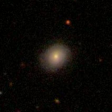

In [167]:
data.train_ds[0][0]

In [168]:
tfms[0][0].tfm

TfmCrop (crop_pad)

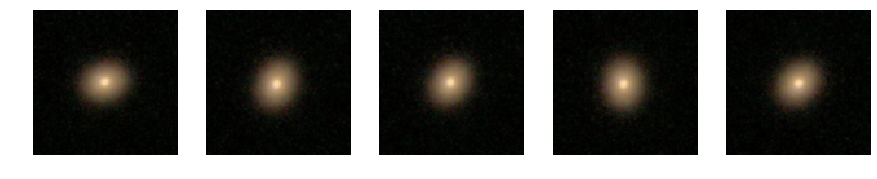

In [169]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 3))

for j in range(5):
    ax = axes[j]
    img = data.train_ds[30][0].apply_tfms(tfms[0])
    img.show(ax=ax)

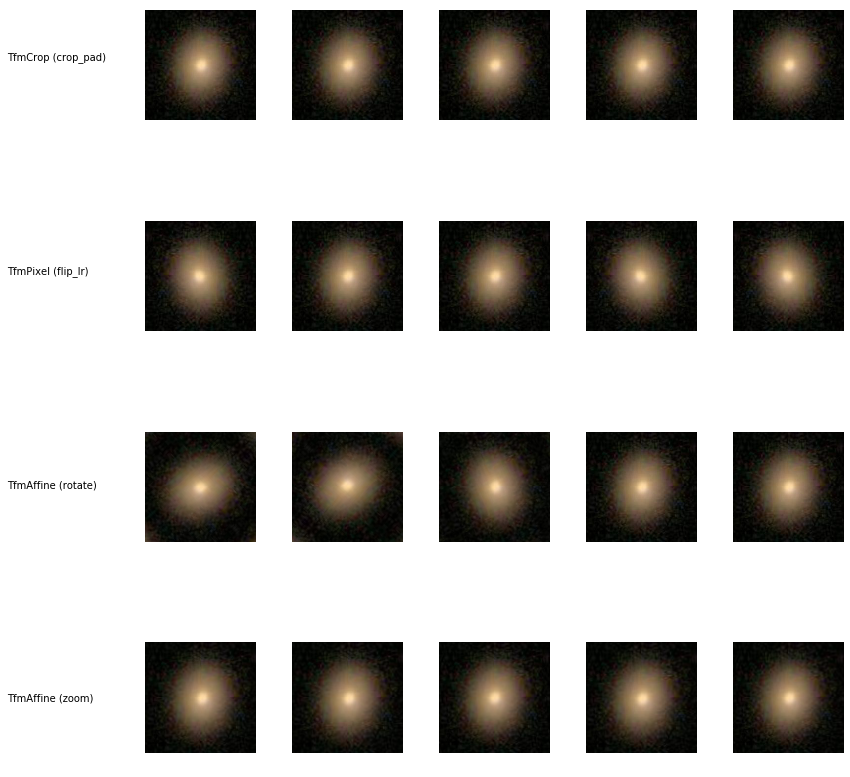

In [175]:
fig, axes = plt.subplots(nrows=len(tfms[0]), ncols=5, figsize=(12, 12))

for i, tfm in enumerate(tfms[0]):
    for j in range(5):
        ax = axes[i, j]
        img = data.train_ds[30][0].apply_tfms(tfm)
        img.show(ax=ax)
        if j == 0:
            ax.text(-140, i * (12 / len(tfms[0])) + 50, str(tfm.tfm))
            
plt.tight_layout()

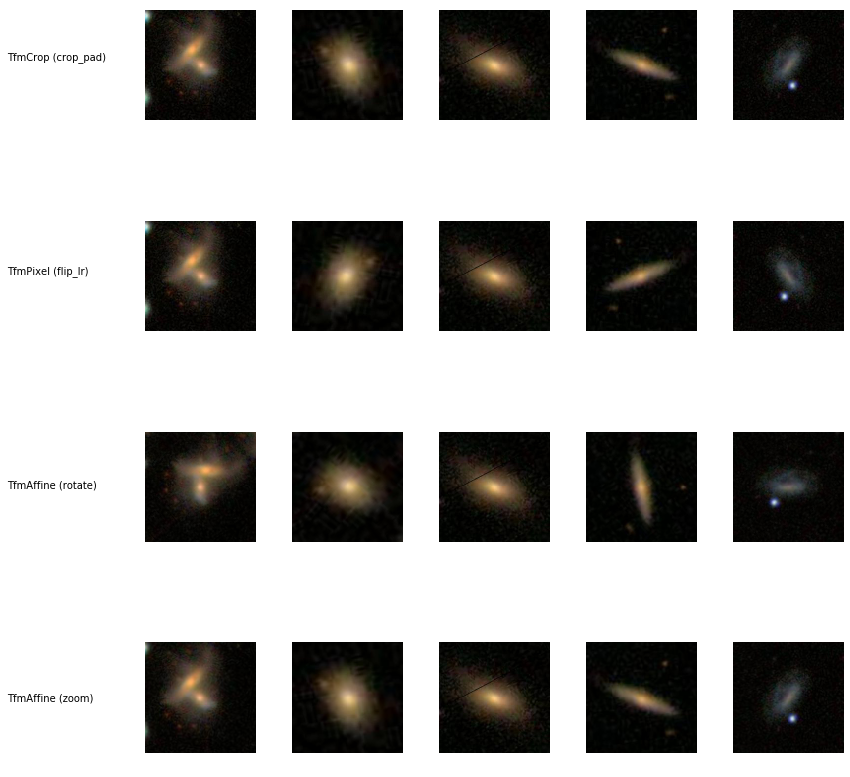

In [186]:
fig, axes = plt.subplots(nrows=len(tfms[0]), ncols=5, figsize=(12, 12))

for i, tfm in enumerate(tfms[0]):
    for j in range(5):
        ax = axes[i, j]
        img = data.train_ds[10+j][0].apply_tfms(tfm)
        img.show(ax=ax)
        if j == 0:
            ax.text(-140, i * (12 / len(tfms[0])) + 50, str(tfm.tfm))
            
plt.tight_layout()

## Train the Model

In [109]:
class GalaxyFloatItem(FloatItem):
    def show(self, ax:plt.Axes, **kwargs):
        "Subclass this method if you want to customize the way this `ItemBase` is shown on `ax`."
        ax.set_title(vec2labels(self.data))
    
    
class GalaxyFloatList(ItemList):
    "`ItemList` suitable for storing the floats in items for regression. Will add a `log` if this flag is `True`."
    def __init__(self, items:Iterator, log:bool=False, classes:Collection=None, **kwargs):
        super().__init__(np.array(items, dtype=np.float32), **kwargs)
        self.log = log
        self.copy_new.append('log')
        self.c = self.items.shape[1] if len(self.items.shape) > 1 else 1
        self.loss_func = MSELossFlat()

    def get(self, i):
        o = super().get(i)
        return GalaxyFloatItem(np.log(o) if self.log else o)

    def reconstruct(self,t): return GalaxyFloatItem(t.numpy())

In [140]:
src = (ImageList.from_csv(path,
                          'training_solutions_rev1.csv', 
                          folder='images_training_rev1_cropped', 
                          suffix='.jpg',
                          cols=0)
            .split_by_rand_pct(0.05, seed=1989)
            .label_from_df(cols=list(range(1, 38)), label_cls=GalaxyFloatList))
data = (src.transform(tfms, size=112, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
           .databunch()).normalize(imagenet_stats)

In [141]:
doc(FloatList)

In [142]:
data.train_ds.y[0]

GalaxyFloatItem [0.383147 0.616853 0.       0.       0.616853 0.038452 0.578401 0.418398 0.198455 0.       0.104752 0.512101 0.
 0.054453 0.945547 0.201463 0.181684 0.       0.       0.027227 0.       0.027227 0.       0.       0.       0.
 0.       0.       0.279952 0.138445 0.       0.       0.092886 0.       0.       0.       0.325512]

In [143]:
doc(data.show_batch)

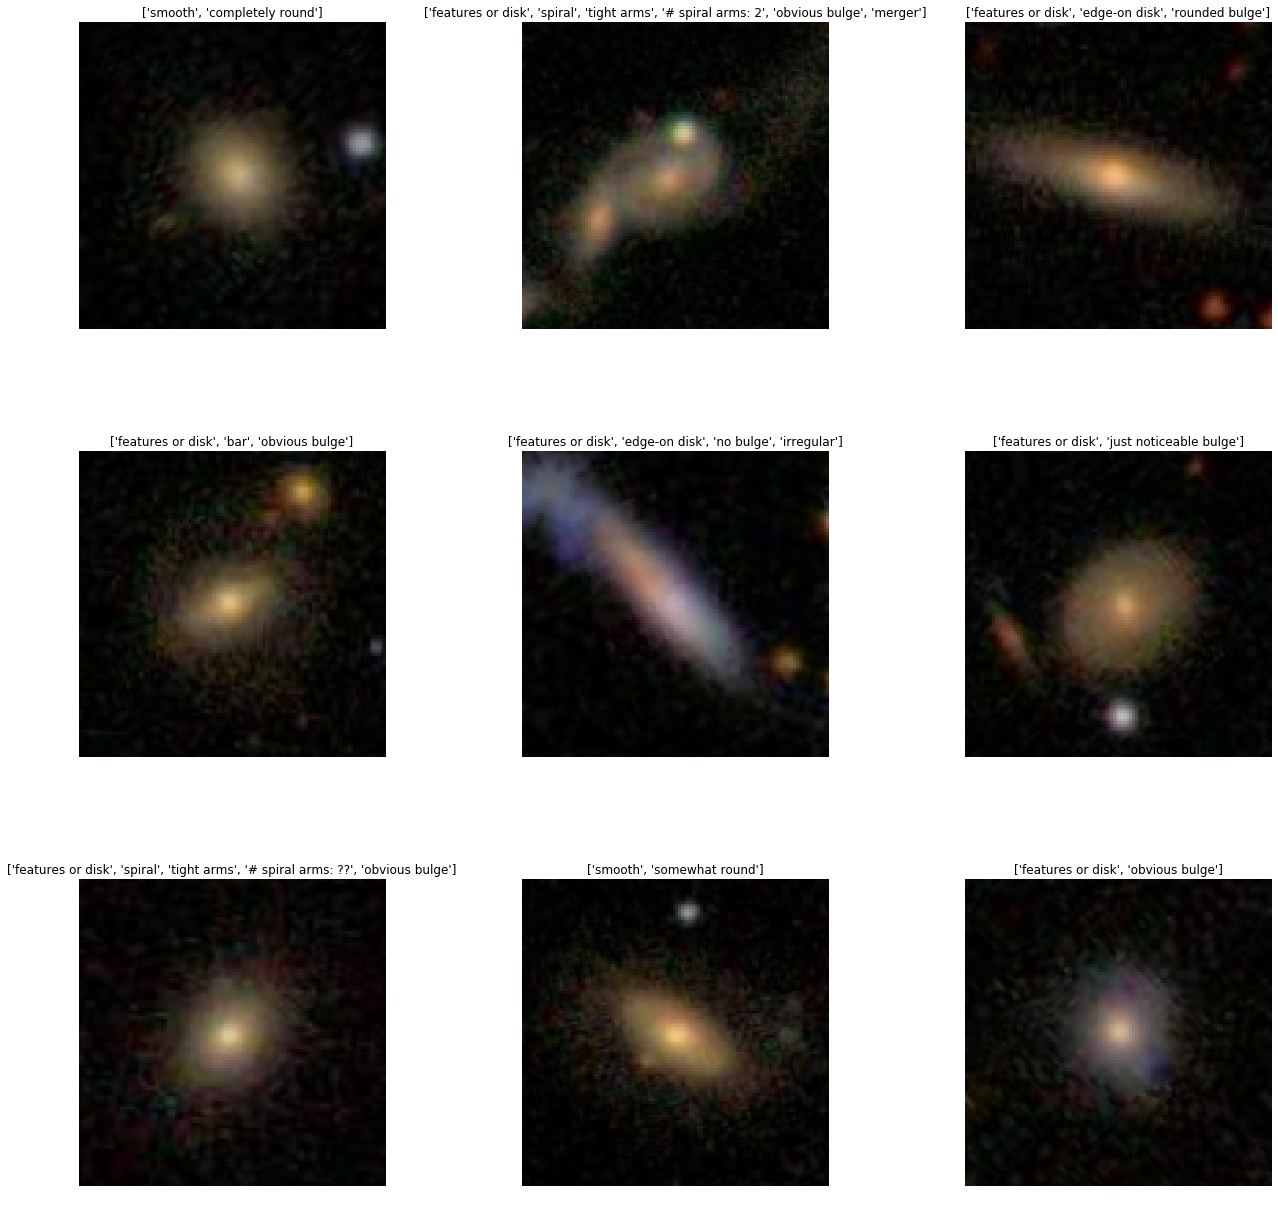

In [144]:
data.show_batch(3, figsize=(18, 18))

In [46]:
!pwd

/Users/jbriggs/Programming/galaxyzoo


In [187]:
learner = cnn_learner(data, models.resnet50, metrics=rmse)#, ps=0.1, wd=1e-4,)# model_dir=Path('/tmp/models/'))
learner.model[-1] = nn.Sequential(*learner.model[-1], GalaxyOutput())

In [188]:
learner.wd

0.01

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr = 5e-2

In [ ]:
learner.wd

In [ ]:
learner.fit_one_cycle(2, lr)

In [ ]:
#learner.save('stage-resnet50-1-1')

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(10, 1e-4)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.save('stage-resnet50-1-2')

In [ ]:
#learner.load('stage-resnet50-1-2');

## Train Full Res

In [190]:
data = (src.transform(tfms, padding_mode='reflection')
        .databunch().normalize(imagenet_stats))

learner.data = data
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
learner.freeze()

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(2, 1e-2/2)

In [ ]:
learner.save('stage-resnet50-224-1-1')

In [ ]:
#learner.load('stage-resnet50-224-1-1');

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(6, 1e-4)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.save('stage-resnet50-224-1-2');

In [ ]:
#learner.load('stage-resnet50-224-1-2');

In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(6, 1e-4)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.fit_one_cycle(6, 1e-4)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.fit_one_cycle(6, 1e-4)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.save('stage-resnet50-224-1-3');

In [ ]:
#learner.load('stage-resnet50-224-1-3');

Some further attempts to squeeze some more performance out. Didn't work...

In [ ]:
#learner.ps=0.5
#learner.wd = 0.001
#learner.fit_one_cycle(8, slice(1e-6, 1e-4/2))

In [ ]:
#learner.recorder.plot_losses()

In [ ]:
#learner.lr_find()
#learner.recorder.plot()

In [ ]:
#learner.ps=0.5
#learner.wd = 0.005
#learner.fit_one_cycle(8, 1e-5)

In [ ]:
#learner.recorder.plot_losses()

In [ ]:
#learner.save('stage-resnet50-224-1-4');

In [ ]:
#learner.load('stage-resnet50-224-1-4');

In [ ]:
#learner.ps=0.5
#learner.wd = 0.01
#learner.fit_one_cycle(8, 1e-5/4)

In [ ]:
#learner.recorder.plot_losses()

In [ ]:
#learner.fit_one_cycle(6, 1e-4/5)

In [ ]:
#learner.predict_with_mc_dropout(data.valid_ds.x[0])

In [ ]:
#!mv /tmp/models/stage-resnet50-224-1-3.pth .

In [ ]:
#from IPython.display import FileLink
#FileLink('stage-resnet50-224-1-4.pth')

In [ ]:
#learner.validate()

## Test Data

In [191]:
learner.load('stage-resnet50-224-1-3');

In [95]:
learner.validate()

[0.0057984707, tensor(0.0760)]

In [ ]:
preds = learner.get_preds(ds_type=DatasetType.Test)

In [193]:
data.test_ds

LabelList (79975 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data